# ML Pipeline

V3 : simple pipeline with few features

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import os
import json
import pickle
import pandas as pd
import numpy as np
import geopandas as gpd
from region_new import Region
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *

from ml.add_all_features import *
from ml.preprocessing import *
from ml.model import *

In [3]:
path = os.path.join("data", "ml", "Ordu.pkl")
with open(path, 'rb') as f:     
    data = pickle.load(f)

In [4]:
data = add_all_features(data,  'Ordu')
save = data.copy()

adding polygons... 
adding denstity... 
adding area... 
adding rasters... 


In [5]:
data = clean_columns(data)

In [6]:
train, pred = split(data)

In [7]:
X, y = training_split(train, 'height')

In [8]:
preprocessor = preprocesor(train)

/home/matt/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


KNeighborsClassifier()
Current Best Score :  0.9703030303030303


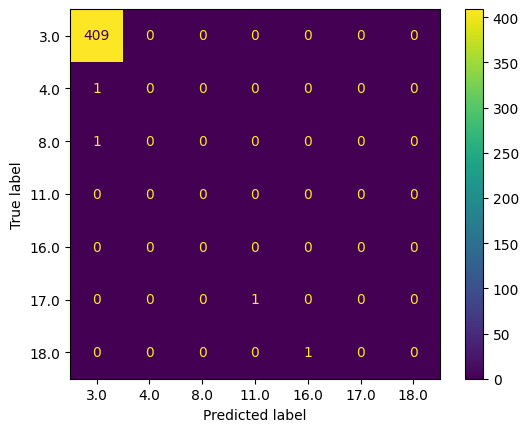

In [9]:
model = select_best_estimator(X, y, preprocessor)

On Ordu for now : all models tend to underestimate the height

In [42]:
prediction = predict(model, 'height', train, pred, save)

/home/matt/wb_cities/ml/model.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set[variable+'_pred'] = train_set[variable]


In [49]:
result = prediction_to_raster(prediction, 'height_pred')

In [51]:
write_result(result, 'Ordu')